In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#
raw_horizon_dir = r"C:\Users\ahmad\Desktop\GEOHACKATHON\horizons"  #Folder containing raw horizon images
horizon_mask_dir = r"C:\Users\ahmad\Desktop\GEOHACKATHON\horizon_masks"  #Folder to save binary masks
raw_seismic_dir = r"C:\Users\ahmad\Desktop\GEOHACKATHON\seismic_images"  #Folder containing seismic images
overlay_output_dir = r"C:\Users\ahmad\Desktop\GEOHACKATHON\overlay_images"  #Folder to save overlayed images

# Create output directories if they don't exist
os.makedirs(horizon_mask_dir, exist_ok=True)
os.makedirs(overlay_output_dir, exist_ok=True)


In [3]:
# Process horizon images and save binary masks
for name in os.listdir(raw_horizon_dir):
    filename = name.split('.')[0]

    # Try loading the image (error handling)
    try:
        img = cv2.imread(os.path.join(raw_horizon_dir, name))
    except Exception as e:
        print(f"Error reading image {name}: {str(e)}")
        continue  # Skip to the next image

    if img is None:
        print(f"Image {name} is empty or corrupted")
        continue  # Skip to the next image

    # Convert to grayscale and process further...
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply binary thresholding
    _, binary_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    binary_image = cv2.bitwise_not(binary_image)

    # Convert to binary format (0 and 1)
    binary_mask = binary_image // 255

    # Save the binary mask as a .npy file
    np.save(os.path.join(horizon_mask_dir, filename + '.npy'), binary_mask)

In [4]:
#Step 2: Overlay seismic images with corresponding horizon masks
for name in os.listdir(raw_seismic_dir):
    filename = os.path.splitext(name)[0].split('-')[-1]
    seismic_path = os.path.join(raw_seismic_dir, name)
    horizon_mask_path = os.path.join(horizon_mask_dir, f"horizon-{filename}.npy")

    # Check if corresponding horizon mask exists
    if not os.path.exists(horizon_mask_path):
        print(f"Warning: No horizon mask found for {filename}. Skipping.")
        continue

    # Load seismic image and horizon mask
    img = cv2.imread(seismic_path)
    horizon_mask = np.load(horizon_mask_path)

    # Invert the horizon mask
    inverted_horizon_mask = cv2.bitwise_not(horizon_mask * 255)

    # Convert binary image to a 3-channel image for overlay (BGR format)
    horizon_mask_bgr = cv2.cvtColor(inverted_horizon_mask, cv2.COLOR_GRAY2BGR)

    # Resize horizon mask to match the seismic image dimensions
    horizon_mask_resized = cv2.resize(horizon_mask_bgr, (img.shape[1], img.shape[0]))

    # Overlay the seismic image and horizon mask
    overlay = cv2.addWeighted(img, 0.5, horizon_mask_resized, 0.5, 0)

    # Save the overlay image
    cv2.imwrite(os.path.join(overlay_output_dir, filename + "_overlay.png"), overlay)

print(f"Overlay process completed. Images saved to {overlay_output_dir}")

Overlay process completed. Images saved to C:\Users\ahmad\Desktop\GEOHACKATHON\overlay_images


In [ ]:
# Convert to grayscale
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply binary thresholding
_, binary_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
binary_image = cv2.bitwise_not(binary_image)

# Convert to binary format (0 and 1)
binary_mask = binary_image // 255

# Save the binary mask as a .npy file
mask_path = os.path.join(horizon_mask_dir, f"{filename}.npy")
np.save(mask_path, binary_mask)
print(f"Binary mask saved for {name} at {mask_path}")

Binary mask saved for seismic-1440.png at C:\Users\ahmad\Desktop\GEOHACKATHON\horizon_masks\1440.npy


In [6]:
# Load the .npy file
file_path = r"C:/Users/ahmad/Desktop/GEOHACKATHON/horizon_masks/1440.npy"  # Replace with your file path
binary_mask = np.load(file_path)

# Print the array
print("Loaded NumPy Array:")
print(binary_mask)

# Check the shape and data type of the array
print("Shape:", binary_mask.shape)
print("Data Type:", binary_mask.dtype)

Loaded NumPy Array:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Shape: (2664, 4166)
Data Type: uint8


In [21]:
import os

def find_mismatched_files(seismic_folder, horizon_folder):
    seismic_files = [int(f.split('-')[1].split('.')[0]) for f in os.listdir(seismic_folder) if f.endswith('.png')]
    horizon_files = [int(f.split('-')[1].split('.')[0]) for f in os.listdir(horizon_folder) if f.endswith('.png')]

    mismatched_horizon_files = set(horizon_files) - set(seismic_files)
    mismatched_seismic_files = set(seismic_files) - set(horizon_files)

    if mismatched_horizon_files:
        print("Horizon files without corresponding seismic files:")
        for file_id in mismatched_horizon_files:
            print(f"horizon-{file_id}.npy")
    else:
        print("No mismatched horizon files found.")

    if mismatched_seismic_files:
        print("\nSeismic files without corresponding horizon files:")
        for file_id in mismatched_seismic_files:
            print(f"seismic-{file_id}.png")
    else:
        print("No mismatched seismic files found.")

# Replace with your actual folder paths
seismic_folder = "C:\\Users\\ahmad\\Desktop\\GEOHACKATHON\\seismic_images"
horizon_folder = "C:\\Users\\ahmad\\Desktop\\GEOHACKATHON\\horizons"

find_mismatched_files(seismic_folder, horizon_folder)

Horizon files without corresponding seismic files:
horizon-1208.npy
horizon-1267.npy
No mismatched seismic files found.


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
 
#Define the paths to your seismic and horizon image folders
seismic_dir = "C:/Users/ahmad/Desktop/GEOHACKATHON/seismic_images"
horizon_dir = r'C:/Users/ahmad/Desktop/GEOHACKATHON/horizons'
 
#Function to load images 
def load_images(seismic_dir, horizon_dir, limit=400, img_size=(256, 256)):
    seismic_images = []
    horizon_masks = []
    # Get all seismic image filenames (assuming they are .png files)
    seismic_files = [f for f in os.listdir(seismic_dir) if f.endswith('.png')][:limit]
    horizon_files = [f for f in os.listdir(horizon_dir) if f.endswith('.png')][:limit]
    # Iterate over the files and load them
    for seismic_file, horizon_file in zip(seismic_files, horizon_files):
        # Load seismic image and horizon mask
        seismic_img_path = os.path.join(seismic_dir, seismic_file)
        horizon_img_path = os.path.join(horizon_dir, horizon_file)
        # Load the seismic image (convert to grayscale if needed)
        seismic_img = image.load_img(seismic_img_path, target_size=img_size)
        seismic_img = image.img_to_array(seismic_img) / 255.0  # Normalize to [0, 1]
        # Load the horizon mask image (assuming binary mask)
        horizon_img = image.load_img(horizon_img_path, target_size=img_size, color_mode='grayscale')
        horizon_img = image.img_to_array(horizon_img) / 255.0  # Normalize to [0, 1]
        seismic_images.append(seismic_img)
        horizon_masks.append(horizon_img)
    return np.array(seismic_images), np.array(horizon_masks)
 
X, y = load_images(seismic_dir, horizon_dir, limit=200, img_size=(256, 256))  # Resize to (64, 64)
 
#Check the shape of loaded data
print(f"Seismic images shape: {X.shape}")
print(f"Horizon masks shape: {y.shape}")

Seismic images shape: (200, 256, 256, 3)
Horizon masks shape: (200, 256, 256, 1)


In [10]:
#Split the data into training, validation, and test sets (80-10-10 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
 
#Check the shape of training and validation sets
print(f"Training data size: {X_train.shape}")
print(f"Validation data size: {X_val.shape}")
print(f"Test data size: {X_test.shape}")

Training data size: (144, 256, 256, 3)
Validation data size: (16, 256, 256, 3)
Test data size: (40, 256, 256, 3)


In [11]:
#Build a simple CNN model for pixel-wise segmentation
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(256, 256, 3)),  # Input layer (grayscale images of size 64x64)
    # Convolutional layers with activation and pooling
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # Upsampling to bring the output back to the original size
    tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu'),
    # Final layer with 1 channel (for binary segmentation), sigmoid activation
    tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')
])
 
#Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
 
#Display the model architecture
model.summary()
 
#Train the model
history = model.fit(
    X_train, y_train,  # Training data and labels
    epochs=30,         # Number of epochs
    batch_size=8,      # Batch size (you can adjust this based on your memory)
    validation_data=(X_val, y_val),  # Validation data
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 256, 256, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,121 (1.27 MB)

 Trainable params: 333,121 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 491ms/step - accuracy: 0.9247 - loss: 0.4522 - val_accuracy: 0.9602 - val_loss: 0.0767
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 451ms/step - accuracy: 0.9602 - loss: 0.0715 - val_accuracy: 0.9602 - val_loss: 0.0601
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 453ms/step - accuracy: 0.9602 - loss: 0.0572 - val_accuracy: 0.9602 - val_loss: 0.0536
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 472ms/step - accuracy: 0.9602 - loss: 0.0533 - val_accuracy: 0.9602 - val_loss: 0.0523
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 478ms/step - accuracy: 0.9600 - loss: 0.0521 - val_accuracy: 0.9602 - val_loss: 0.0515
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 424ms/step - accuracy: 0.9608 - loss: 0.0505 - val_accuracy: 0.9602 - val_loss: 0.0505
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 430ms/step - accuracy: 0.9610 - loss: 0.0491 - val_accuracy: 0.9602 - val_loss: 0.0486
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 466ms/step - accuracy: 0.9607 - loss: 0.0472 - val_accuracy: 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step
Predictions shape: (40, 256, 256, 1)
Binary Predictions shape: (40, 256, 256, 1)


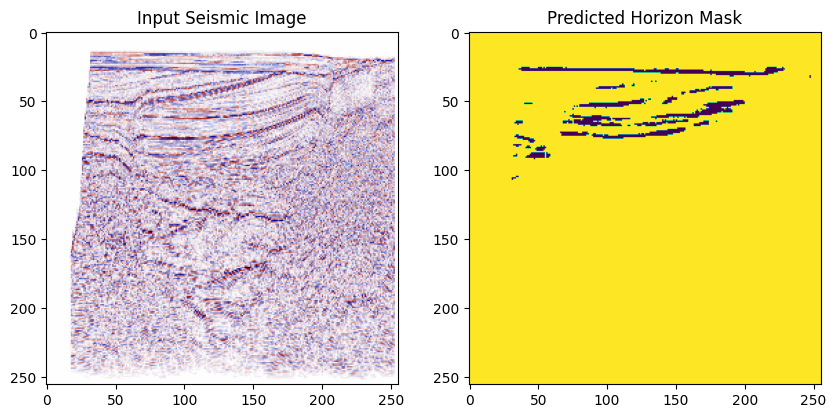

In [18]:
#Make predictions on the test set
predictions = model.predict(X_test)
 
#Check the shape of predictions
print(f"Predictions shape: {predictions.shape}")  # Should be (num_samples, 64, 64, 1)
 
#Convert predictions to binary values (0 or 1) using a threshold of 0.5
predictions_binary = (predictions > 0.9).astype(np.uint8)
 
#Check the shape of binary predictions
print(f"Binary Predictions shape: {predictions_binary.shape}")  # Should also be (num_samples, 64, 64, 1)
 
#If you want to visualize the first prediction, you can do something like this:
import matplotlib.pyplot as plt
 
#Visualize the first prediction (image and corresponding mask)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_test[0].squeeze())  # Input seismic image (grayscale)
plt.title("Input Seismic Image")
 
plt.subplot(1, 2, 2)
plt.imshow(predictions_binary[1].squeeze())  # Predicted mask (binary)
plt.title("Predicted Horizon Mask")
 
plt.show()

In [20]:
import os

def find_mismatched_files(seismic_folder, horizon_folder):
    seismic_files = [int(f.split('-')[1].split('.')[0]) for f in os.listdir(seismic_folder) if f.endswith('.png')]
    horizon_files = [int(f.split('-')[1].split('.')[0]) for f in os.listdir(horizon_folder) if f.endswith('.png')]

    mismatched_horizon_files = set(horizon_files) - set(seismic_files)
    mismatched_seismic_files = set(seismic_files) - set(horizon_files)

    if mismatched_horizon_files:
        print("Horizon files without corresponding seismic files:")
        for file_id in mismatched_horizon_files:
            print(f"horizon-{file_id}.npy")
    else:
        print("No mismatched horizon files found.")

    if mismatched_seismic_files:
        print("\nSeismic files without corresponding horizon files:")
        for file_id in mismatched_seismic_files:
            print(f"seismic-{file_id}.png")
    else:
        print("No mismatched seismic files found.")

# Replace with your actual folder paths
seismic_folder = "C:\\Users\\ahmad\\Desktop\\GEOHACKATHON\\seismic_images"
horizon_folder = "C:\\Users\\ahmad\\Desktop\\GEOHACKATHON\\horizons"

find_mismatched_files(seismic_folder, horizon_folder)

Horizon files without corresponding seismic files:
horizon-1208.npy
horizon-1267.npy
No mismatched seismic files found.
